In [1]:
from models import *
from spring_data import *
from train import *
from util import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def lagrangian(q, dq):
    return dq**2 - q**2
F = lagrangian(q[:-1], dq)
plt.plot(F)
plt.show()

In [ ]:
def Euler_Lagrange(model, y0, y1, dt):
    L_0 = model(y0)
    dLdq_0 = model.derivatives(y0)[0]
    L_1 = model(y1)
    dLdq_1 = model.derivatives(y1)[0]
    #print((dLdq_1[1] - dLdq_0[1]) / dt, dLdq_0[0])
    return ((dLdq_1[1] - dLdq_0[1]) / dt - dLdq_0[0]) ** 2


def train(model, x, c, epoch = 10, t_eval = 0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for ep in range(epoch):
        loss = 0
        for i in range(0, len(x) - 1):
            #print(x[i].double(), x[i + 1].double())
            dt = t_eval[i + 1] - t_eval[i]
            control_loss = (Euler_Lagrange(model, x[i], x[i + 1], dt) + 1e-10) / (Euler_Lagrange(model, c[i], c[i + 1], dt) + 1e-10)
            #loss += f(Euler_Lagrange_normalizer(model, x[i], x[i + 1], dt)) * f(Euler_Lagrange(model, x[i], x[i + 1], dt)) * control_loss
            loss += f(Euler_Lagrange(model, x[i], x[i + 1], dt))
        if (ep + 1) % 50 == 0:
            print(loss)
            result = []
            for xi in x:
                l = model(xi.detach())
                result.append(l)
            plt.plot(result)
            plt.show()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [98]:
m = 1
k = 1

def differential_equation(t, w):
    x, y = w
    return [y, - (k / m) * x]

def gen_spring_data(y0 = [1, 1]):
    x = []
    v = []
    t_span = [0, 50]
    timescale=10
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))
    spring_ivp = solve_ivp(fun=differential_equation, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10)
    x, v = spring_ivp['y'][0], spring_ivp['y'][1]
    dL = np.concatenate([-  k * x.reshape(-1, 1), m * v.reshape(-1, 1)], axis = 1)
    q = np.concatenate([np.array(x).reshape(-1, 1), np.array(v).reshape(-1, 1)], axis = 1)
    return q, dL, t_eval

def compute_lagrange(x):
    x , v = x[:, 0], x[:, 1]
    print(x.shape)
    print(v.shape)
    L = []
    H = []
    for i in range(x.shape[0]):
        L.append(1/2 * m * v[i]**2 - 1 / 2 * k * x[i]**2)
        H.append(1/2 * m * v[i]**2 + 1 / 2 * k * x[i]**2)
    return L, H



(500, 2)
(500,)
(500,)


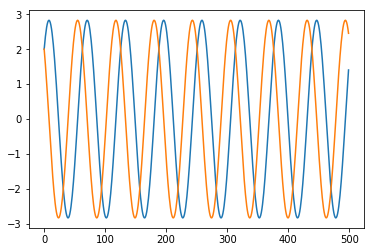

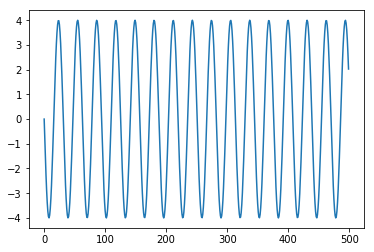

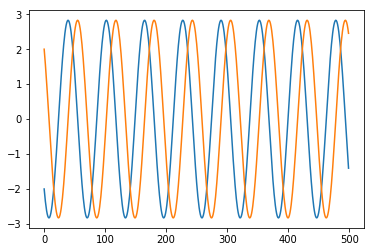

In [99]:
x, dL, _ = gen_spring_data([2,2])
print(dL.shape)
L, H = compute_lagrange(x)
x , v = x[:, 0], x[:, 1]
plt.plot(x)
plt.plot(v)
plt.show()
plt.plot(1/2*m*v**2 - 1/2*k*x**2)
plt.show()
plt.plot(dL[:, 0])
plt.plot(dL[:, 1])
plt.show()

In [96]:


def Euler_Lagrange(model, y0, y1, dt):
    L_0 = model(y0)
    dLdq_0 = model.derivatives(y0)[0]
    L_1 = model(y1)
    dLdq_1 = model.derivatives(y1)[0]
    #print((dLdq_1[1] - dLdq_0[1]) / dt, dLdq_0[0])
    return ((dLdq_1[1] - dLdq_0[1]) / dt - dLdq_0[0]) ** 2


def train(model, x, dL, epoch = 10, t_eval = 0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    for ep in range(epoch):
        total_loss = 0
        control_loss = 0
        loss = 0
        normalizer = 0
        for i in range(0, len(x) - 1):
            dt = t_eval[i + 1] - t_eval[i]
            control_loss += Euler_Lagrange(model, c[i], c[i + 1], dt)
            #loss = f(Euler_Lagrange_normalizer(model, x[i], x[i + 1], dt)) * f(Euler_Lagrange(model, x[i], x[i + 1], dt)) * control_loss
            normalizer += f(Euler_Lagrange_normalizer(model, x[i], x[i + 1], dt))
            loss += Euler_Lagrange(model, x[i], x[i + 1], dt)
        total_loss = normalizer * loss * (loss + 1e-10) / (control_loss + 1e-10)
        if (ep + 1) % 100 == 0:
            print(total_loss.item())
            print(loss.item(), control_loss.item())
            L = []
            result = []
            for xi in x:
                lag = model(xi.detach())
                l = model.derivatives(xi)[0].detach().numpy()
                result.append(l)
                L.append(lag)
            result = np.array(result)
            plt.plot(L)
            plt.show()
            plt.plot(result)
            plt.show()
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()


/Users/fischer/UCSD/SuLab/neural-ode/LagrangianNet/models.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.linear1.weight)
/Users/fischer/UCSD/SuLab/neural-ode/LagrangianNet/models.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.linear2.weight)
/Users/fischer/UCSD/SuLab/neural-ode/LagrangianNet/models.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.linear3.weight)


30775.6354278001
371.27190368116567 2115.49374555944


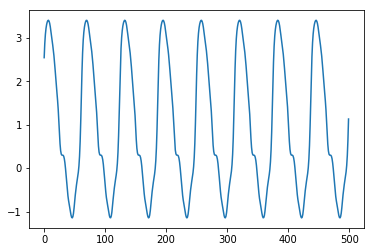

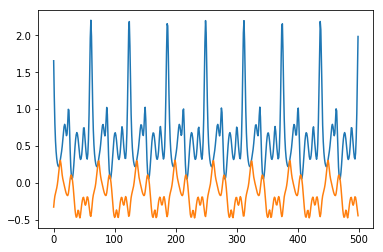

20463.917496489794
337.65932902738666 2176.3092348609416


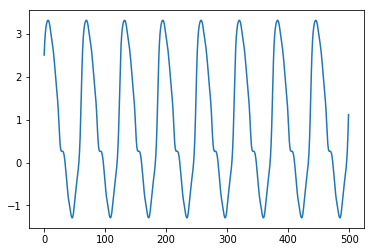

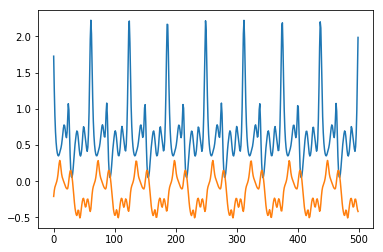

KeyboardInterrupt: 

In [101]:

x, _, t_eval = gen_spring_data([2,2])
c = np.linspace(x[0], x[-1], 500)
x = torch.from_numpy(x)
c = torch.from_numpy(c)
x.requires_grad = True
c.requires_grad = True

model = Lagrange_NET(2,8,1).double()
train(model, x, c, 3000, t_eval)

In [14]:
data = get_dataset()
x = data['x']
print(x.shape)

(750, 2)


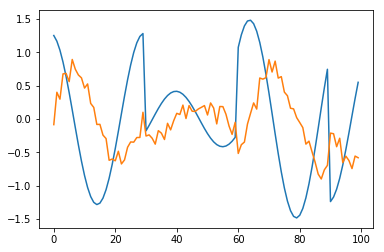

In [20]:
dxdt = data['dx']
plt.plot(dxdt[:100, 0])
plt.plot(x[:100, 0])